## Sagnac Frequency - Backscatter Correction - Mulit-Regression Model

Explore the longterm behaviour of the RU sagnac beat

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream, read_inventory
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor

from functions.get_fft import __get_fft
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd
from functions.load_beam_wander_data import __load_beam_wander_data
from functions.reduce import __reduce

from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml
from andbro__load_FURT_stream import __load_furt_stream

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

## Configurations

In [3]:
config = {}

config['ring'] = "V"

config['seed'] = f"BW.DROMY..FJ{config['ring']}"

config['path_to_sds'] = archive_path+"romy_archive/"

# first test
# config['tbeg'] = UTCDateTime("2024-05-22 00:00")
# config['tend'] = UTCDateTime("2024-05-31 00:00")
# flim1, flim2 = 447.726, 447.736

config['file'] = f"multi_regression_R{config['ring']}_df0.pkl"
config['file'] = f"multi_regression_R{config['ring']}_df1.pkl"

## path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"

config['path_to_out_data'] = data_path+"sagnac_frequency/data/"


config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

config['colors'] = {  1:'darkgreen',
                      3:'lightgreen',
                      4:'purple',
                      5:'darkred',
                      6:'darkblue',
                      7:'darkorange',
                      8:'darkcyan',
                      9:'cyan',
                     }

## Methods

In [4]:
def __makeplot_corr_matrix(ddf, target, m="pearson"):

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    _df = ddf.copy()

    if "time" in list(_df.columns):
        _df.drop(columns="time", inplace=True)

    _df = _df.iloc[:, :]

    corr = _df.corr(method=m)

    # mask upper triangle
    corr[:] = np.where(np.arange(corr.shape[0])[:, None] >= np.arange(corr.shape[1]), np.nan, corr)

    print(corr)

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(6, 5))

    # Generate a custom diverging colormap
    # cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=100)
    cmap = plt.get_cmap("coolwarm", 9)

    # Generate a mask for the upper triangle
    # mask = np.zeros_like(corr, dtype=bool)
    # mask[np.triu_indices_from(mask)] = True

    # Draw the heatmap with the mask and correct aspect ratio
    # sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5)

    im = plt.pcolor(corr, cmap=cmap, vmin=-.9, vmax=.9, edgecolors='w', linewidths=2, alpha=0.9)

    plt.colorbar(im, extend="both")

    labels = list(corr.columns)
    ax = plt.gca()
    ax.set_xticks(np.arange(len(labels))+0.5)
    ax.set_xticklabels(labels)
    ax.set_yticks(np.arange(len(labels))+0.5)
    ax.set_yticklabels(labels)


    fig.suptitle(f'{m} correlation matrix', fontsize=15)

    fig.tight_layout();

    return fig

In [5]:
def __find_model(ddf, _features, target="fj_fs", reg="theilsen"):

    _df = ddf.copy()

    # remove time and target
    try:
        _features.remove(target)
    except:
        pass
    try:
        _features.remove("time")
    except:
        pass

    print(_features)

    # define x data
    X = _df[_features].values.reshape(-1, len(_features))

    # define y data
    y = _df[target].values

    # multi linear regression

    # using OLS
    if reg.lower() == "ols":
        ols = linear_model.LinearRegression()
        model = ols.fit(X, y)

        print("R2:", model.score(X, y))
        print("X0:",  model.intercept_)
        print("Coef: ",  model.coef_)
        for _f, _c in zip(features_model, model.coef_):
            print(f"{_f} : {_c}")

    elif reg.lower() == "ransac":
        model = RANSACRegressor(random_state=1).fit(X, y)
        print("R2:", model.score(X, y))
        print("Coef: ",  model.estimator_.coef_)
        for _f, _c in zip(features_model, model.estimator_.coef_):
            print(f"{_f} : {_c}")

    # using TheilSen
    elif reg.lower() == "theilsen":
        model = TheilSenRegressor().fit(X, y)

        print("R2:", model.score(X, y))
        print("X0:",  model.intercept_)
        print("Coef: ",  model.coef_)
        for _f, _c in zip(features_model, model.coef_):
            print(f"{_f} : {_c}")

    # prediction
    model_predict = []

    for o, row in _df[_features].iterrows():

        x_pred = []
        for feat in _features:
            x_pred.append(row[feat])

        x_pred = np.array(x_pred)
        x_pred = x_pred.reshape(-1, len(_features))

        model_predict.append(model.predict(x_pred))

    out = {}
    out['model'] = model
    out['r2'] = model.score(X, y)
    out['tp'] = _df.time
    out['dp'] = model_predict

    # plt.plot(_df.time, model_predict)
    # plt.plot(_df.time, _df[target].values)
    return out

In [6]:
def __predict_data(df_in, _features, _model, target="fj_fs"):

    from numpy import array

    _df = df_in.copy()

    # remove time and target
    try:
        _features.remove(target)
    except:
        pass
    try:
        _features.remove("time")
    except:
        pass

    # prediction
    model_predict = []

    for o, row in _df[_features].iterrows():

        x_pred = []
        for feat in _features:
            x_pred.append(row[feat])

        x_pred = np.array(x_pred)
        x_pred = x_pred.reshape(-1, len(_features))

        model_predict.append(_model.predict(x_pred))

    return array(_df.time), array(model_predict)

In [7]:
def __makeplot(df0, modell, target):

    import matplotlib.pyplot as plt

    tscale = 1/86400

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax.plot(df0.time*tscale, df[target], color="k", label="observed")
    ax.plot(df0.time*tscale, modell['dp'], color="tab:red", label="predicted")

    ax.grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

    ax.legend(loc=4, fontsize=font-2)

    ax.set_ylabel(f"$\Delta$f (Hz)", fontsize=font)
    ax.set_xlabel("Time (days)", fontsize=font)

    ax.text(0.01, 0.97, f"R$^2$={modell['r2']:.2f}", ha="left", va="top", transform=ax.transAxes, fontsize=font-1)

    ax.set_xlim(min(df0.time*tscale), max(df0.time*tscale))

    ax.set_title(target)

    plt.show();
    return fig

In [8]:
def __makeplot2(df0, df1, tp, dp, model, target):

    import matplotlib.pyplot as plt

    tscale = 1/86400

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 4), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax.plot(df0.time*tscale, df0[target], color="k", label="observed (training)", alpha=0.7)
    ax.plot(model['tp']*tscale, model['dp'], color="tab:red", label="predicted (training)", alpha=0.7)

    ax.fill_betweenx([-1000, 1000], df0.time.min()*tscale, df0.time.max()*tscale, color="grey", alpha=0.3)

    ax.plot(df1.time*tscale, df1[target], color="k", label="observed")
    ax.plot(tp*tscale, dp, color="darkred", label="predicted")

    ax.grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

    ax.legend(loc=8, fontsize=font-2, ncol=2)

    ax.set_ylabel(f"Displacement (mm)", fontsize=font)
    ax.set_xlabel("Time (days)", fontsize=font)

    ax.text(0.01, 0.97, f"R$^2$={out['r2']:.3f}", ha="left", va="top", transform=ax.transAxes, fontsize=font-1)

    ax.set_xlim(0, df1.time.max()*tscale)

    if target == "bwy":
        ax.set_ylim(-0.01, 0.055)
    if target == "bwx":
        ax.set_ylim(-0.002, 0.005)

    ax.set_title(target)

    plt.show();
    return fig

### Read Dataframe

In [9]:
# os.listdir(config['path_to_out_data'])

In [10]:
df = read_pickle(config['path_to_out_data']+config['file'])

In [11]:
# df.plot(x="time", y=list(df.columns), subplots=True, figsize=(15, 10))

### Add Hilbert Transfrom of Air Pressure

### Define features

In [12]:
from functions.smoothing import __smooth
from functions.interpolate_nan import __interpolate_nan

In [13]:
df['fj_bs'] = __interpolate_nan(__smooth(df.fj_bs, 30))

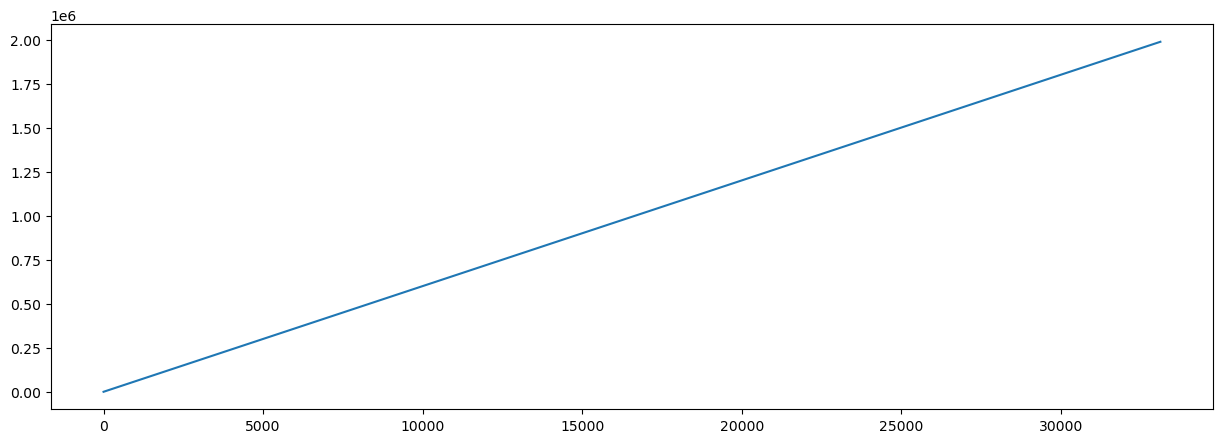

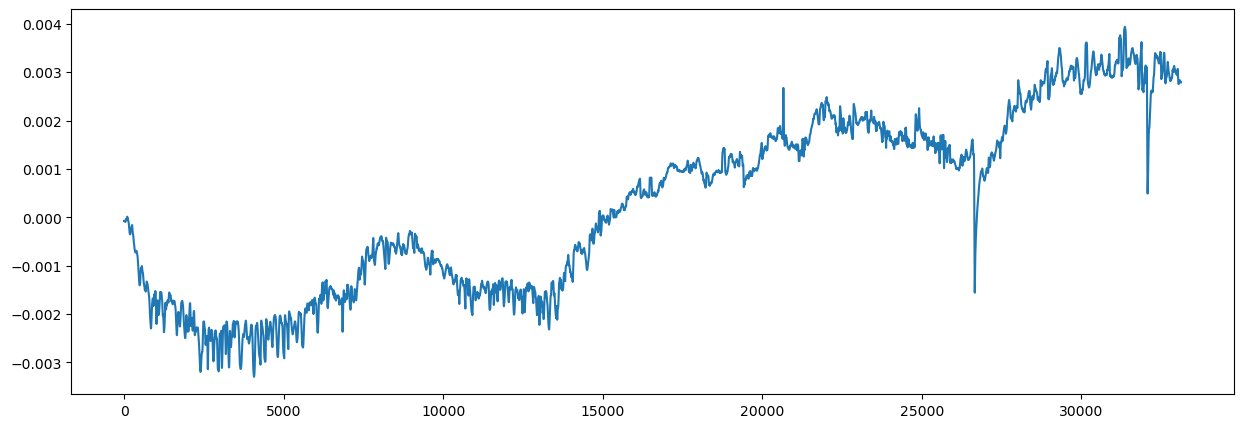

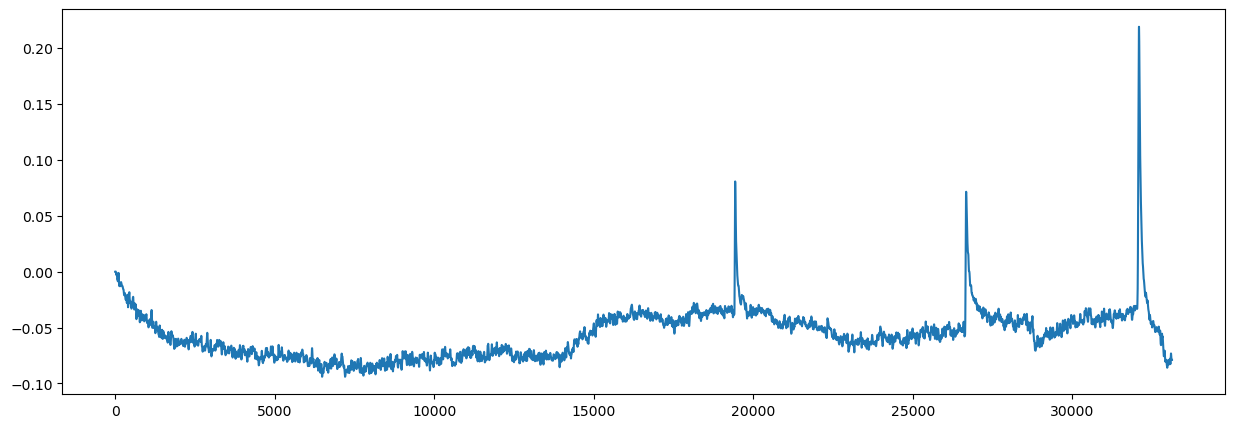

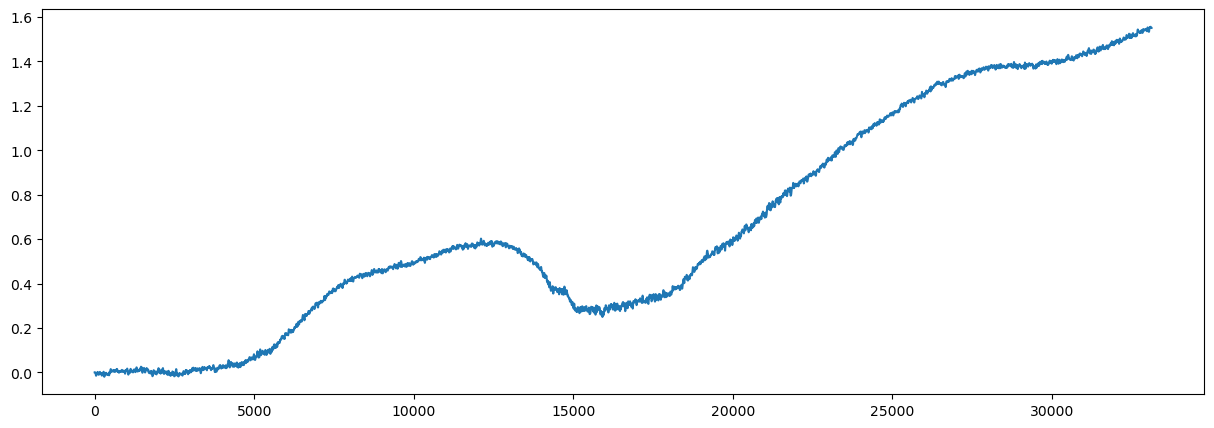

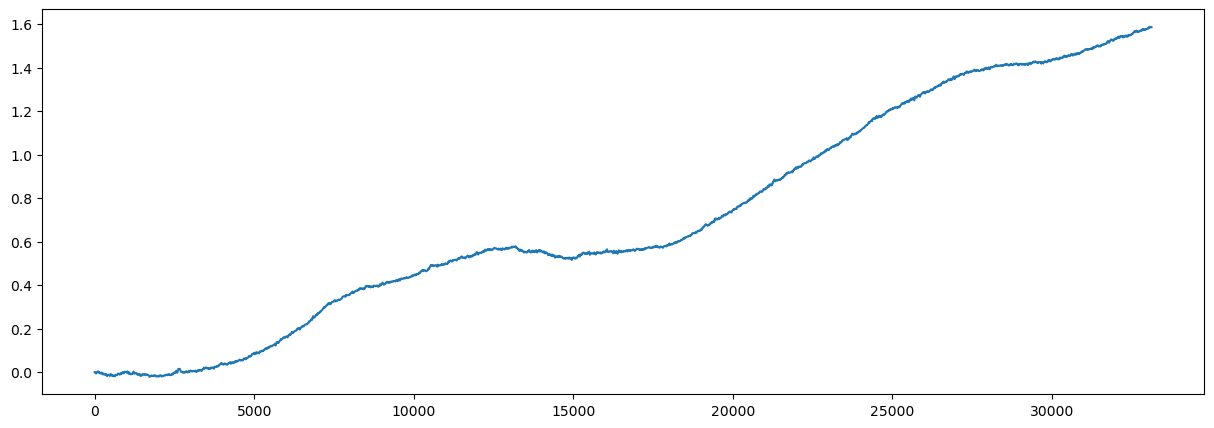

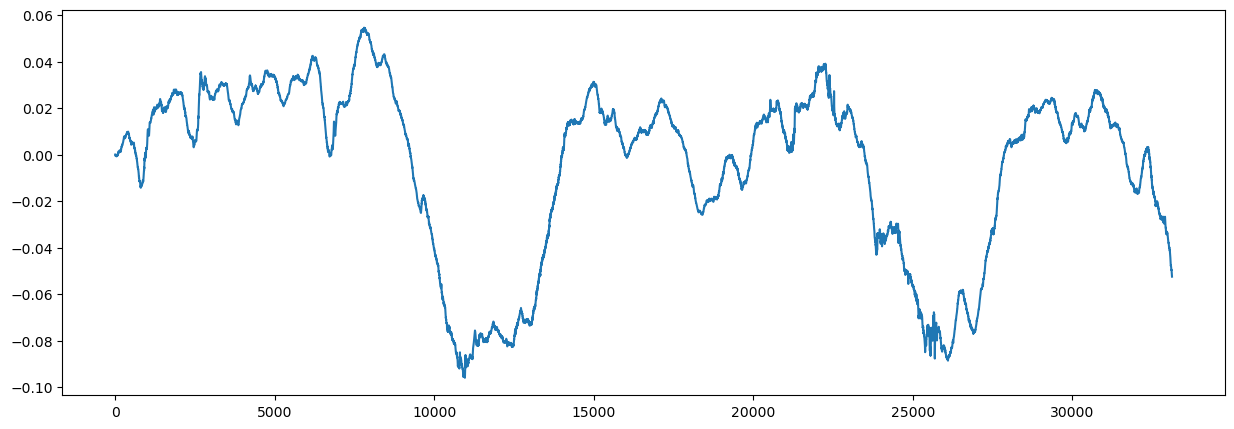

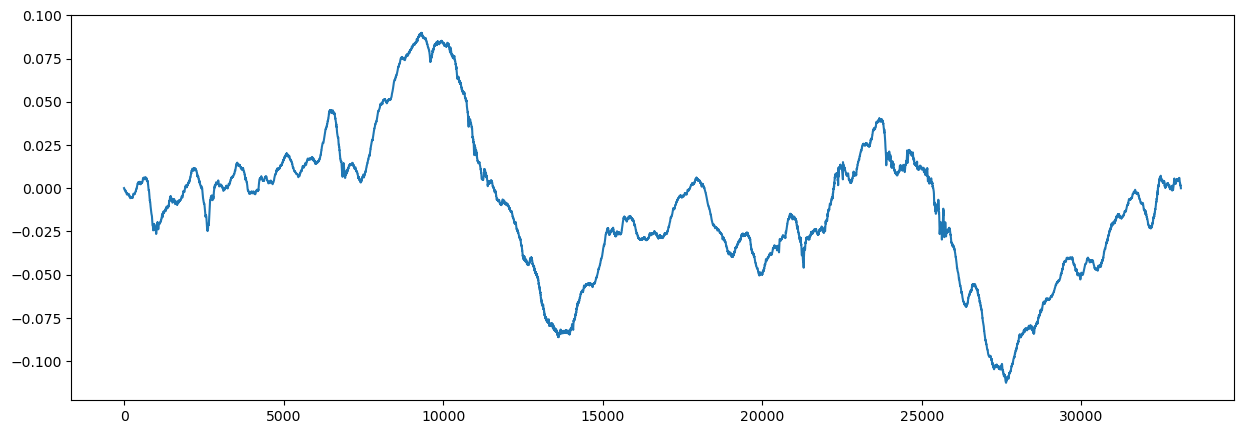

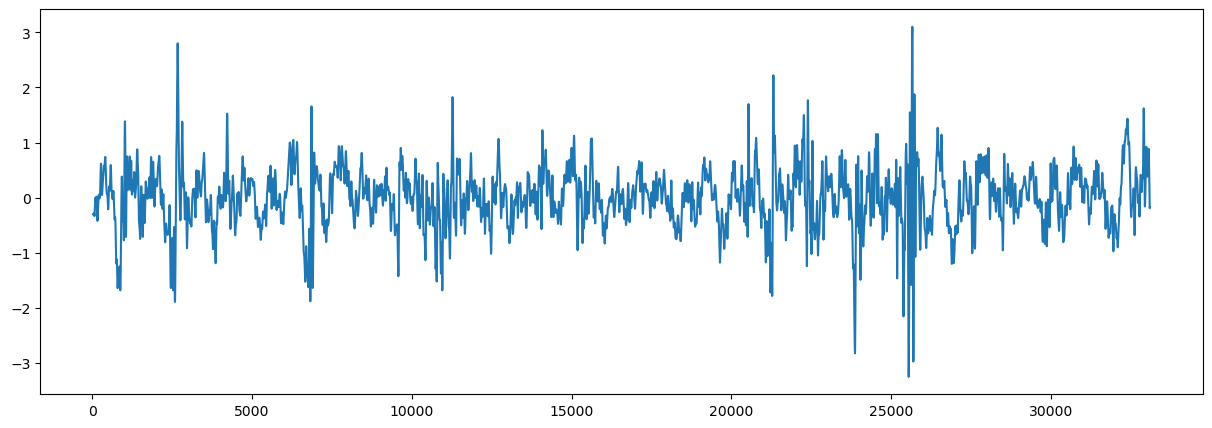

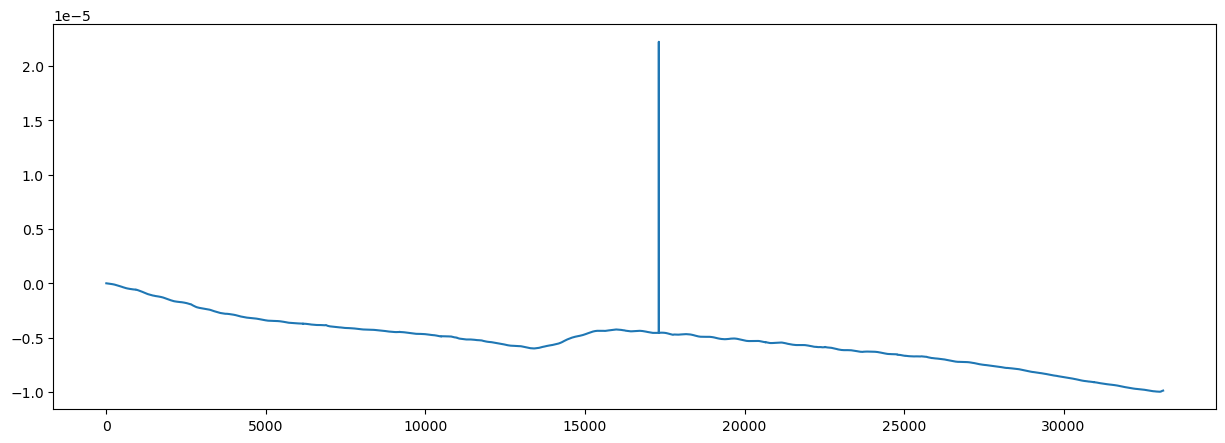

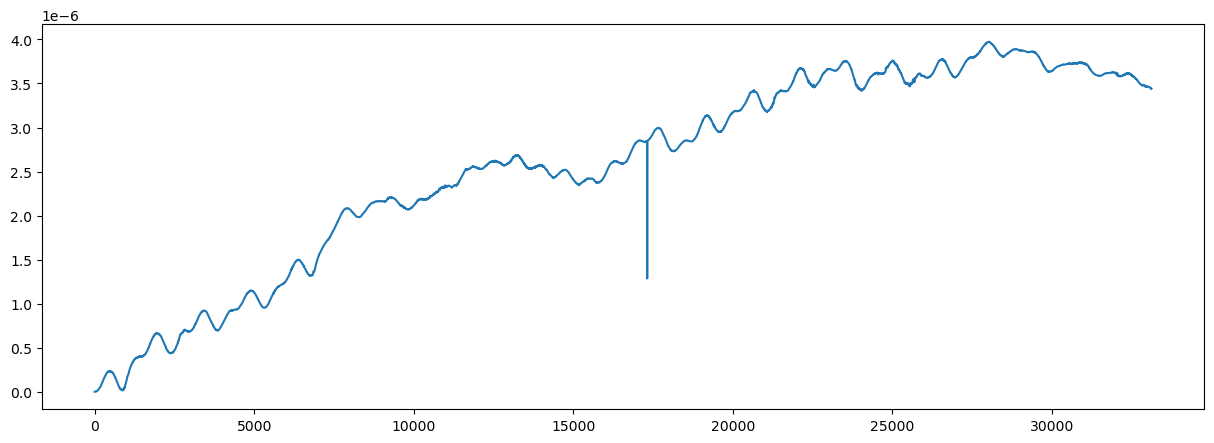

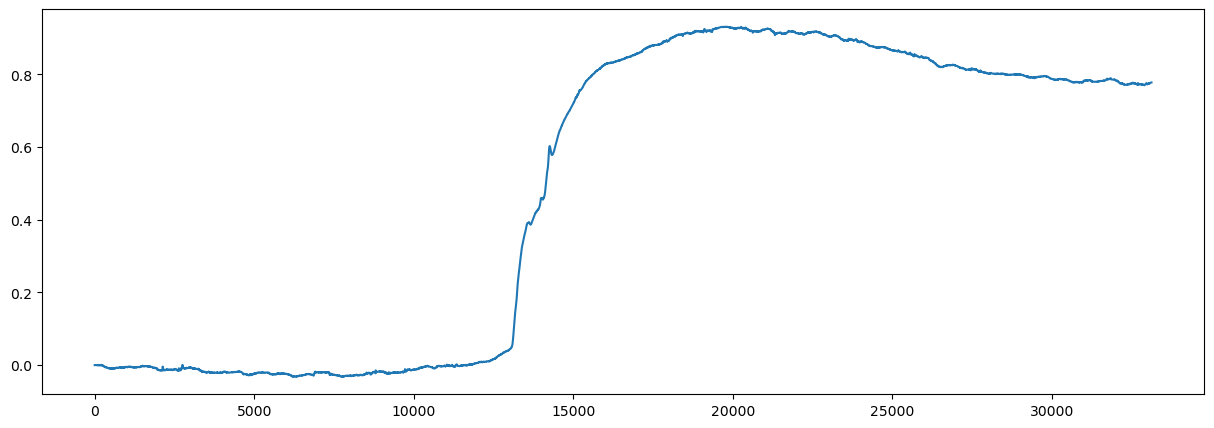

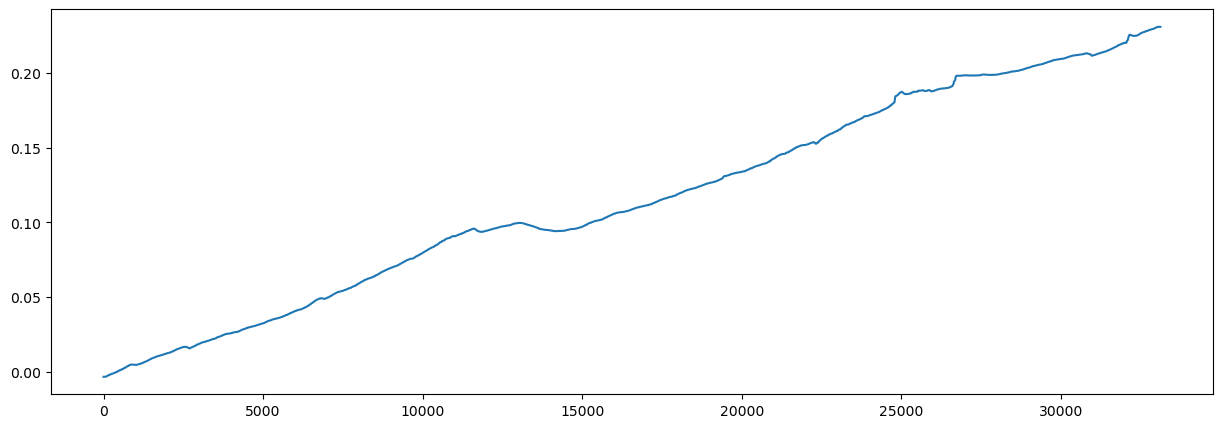

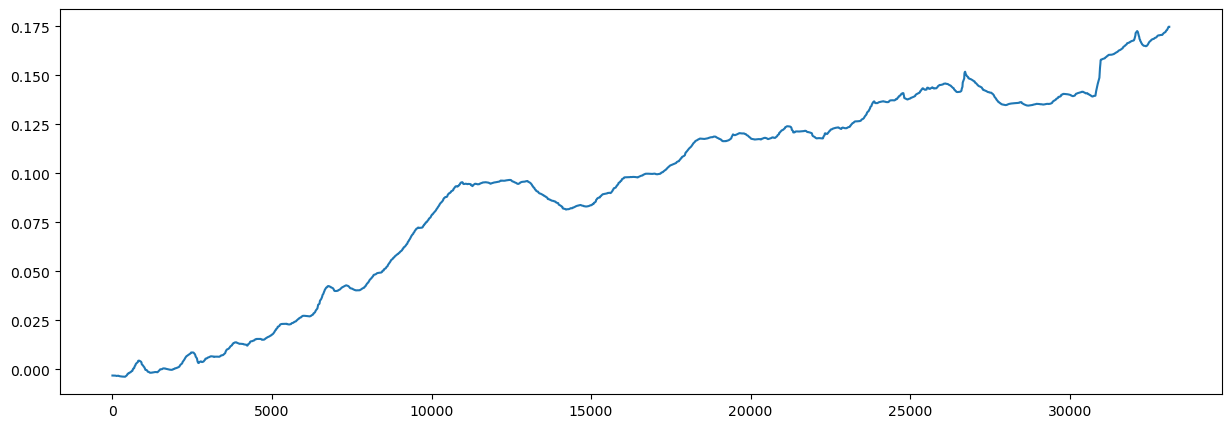

In [14]:
for k in df.keys():
    plt.figure(figsize=(15, 5))
    plt.plot(df[k])

In [15]:
def __makeplot3(df0, df1, df2,
                tp1, dp1, model1, target1,
               ):

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    from numpy import array

    def __corr(df_in, m="kendall", targetx="not_the_one"):

        _df = df_in.copy()

        if "time" in list(_df.columns):
            _df.drop(columns="time", inplace=True)
        # if targetx in list(_df.columns):
        #     _df.drop(columns=targetx, inplace=True)


        _df = _df.iloc[:, :]

        corr = _df.corr(method=m.lower())

        # mask upper triangle
        corr[:] = np.where(np.arange(corr.shape[0])[:, None] >= np.arange(corr.shape[1]), np.nan, corr)

        return corr

    def __rmse(arr1, arr2):
        return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 4)

    def __variance_reduction(arr1, arr2):
        from numpy import var
        vr = round(( var(arr1) - var(arr2) ) / var(arr1) * 100, 2)
        return vr


    # correlatin matrix
    c_method = "Kendall" # kendall pearson spearman
    corr1 = __corr(df0, m=c_method, targetx=target1)

    # variance reduction
    dat = array(df2[target1])
    res = dat - dp1
    VR = __variance_reduction(dat, res)

    # root mean square error
    rmse = __rmse(dat, dp1)

    # _________________________________________
    #

    yscale, yunit = 1e3, "mHz"

    tscale = 1/86400

    Nrow, Ncol = 1, 10

    cmap = plt.get_cmap("coolwarm", 9)

    fig = plt.figure(figsize=(15, 5))

    font = 12

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0.1, wspace=0.7)

    ax0 = fig.add_subplot(gs[0, :7])
    ax1 = fig.add_subplot(gs[0, 7:])

    axes = [ax0, ax1]


    ax0.plot(df1.time*tscale, df1[target1]*yscale, color="k", label="observed (training)", alpha=0.7)
    ax0.plot(model1['tp']*tscale, array(model1['dp'])*yscale, color="tab:red", label="predicted (training)", alpha=0.7)

    ax0.fill_betweenx([-1000, 1000], df1.time.min()*tscale, df1.time.max()*tscale, color="grey", alpha=0.3)

    ax0.plot(df2.time*tscale, df2[target1]*yscale, color="k", label="observed")
    ax0.plot(tp1*tscale, dp1*yscale, color="darkred", label="predicted")

    ax0.set_xticklabels([])

    im1 = ax1.pcolor(corr1, cmap=cmap, vmin=-.9, vmax=.9, edgecolors='w', linewidths=2, alpha=0.9)

    # add colorbar
    cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77]) #[left, bottom, width, height]
    cb = plt.colorbar(im1, cax=cbar_ax, extend="both")

    labels = list(corr1.columns)
    # ax1.yaxis.set_label_position("right")
    # ax1.yaxis.tick_right()
    ax1.set_xticks(np.arange(len(labels))+0.5)
    ax1.set_xticklabels(labels)
    ax1.set_yticks(np.arange(len(labels))+0.5)
    # ax1.set_yticklabels(reversed(labels))
    ax1.set_yticklabels(labels)

    ax1.text(0.5, 0.97, f"{c_method} correlation", ha="center", va="top", transform=ax1.transAxes, fontsize=font-1)

    for ax in [ax0]:

        ax.grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)
        ax.legend(loc=9, fontsize=font-2, ncol=2)
        ax.set_ylabel(f"$\Delta$f ({yunit})", fontsize=font)

    ax0.text(0.97, 0.97, f"R$^2$ = {model1['r2']:.3f}", ha="right", va="top", transform=ax0.transAxes, fontsize=font-1)

    ax0.text(0.97, 0.90, f"$\sigma_R$ = {VR:.2f}%", ha="right", va="top", transform=ax0.transAxes, fontsize=font-1)

    ax0.text(0.97, 0.82, f"RMSE = {rmse:.5f}", ha="right", va="top", transform=ax0.transAxes, fontsize=font-1)

    ax0.set_xlim(0, df2.time.max()*tscale)

    # ax0.set_ylim(-0.01, 0.055)

    ax0.set_ylim(df0[target1].min()*yscale*1.2, df0[target1].max()*yscale*5)

    mod = ""
    for i, ll in enumerate(features_model):
        mod += f"c$_{i}$ ${ll}$ + "

    tit1 = f"{target1} = {mod}"
    ax0.set_title(tit1[:-2])

    axes = [ax0, ax1]
    for _k, (ax, ll) in enumerate(zip(axes, ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)'])):
        ax.text(.01, .98, ll, ha='left', va='top', transform=ax.transAxes, fontsize=font+2)


    plt.show();
    return fig

In [18]:

featuresx = ['time', 'fj_bs', 'bwx', 'bwy', 'bdo', 'hp', 'ps1', 'ps7', 'ps9', 'mae', 'man', 'peg']

dfx = df[featuresx].copy()

targetx = "fj_bs"

N = dfx.shape[0]

df1_part1 = dfx.iloc[:int(N/2)]
df1_part2 = dfx.iloc[int(N/2):]

features_model = ['time', 'fj_bs', 'bwx', 'bwy', 'bdo', 'hp', 'ps1', 'ps7', 'ps9', 'mae', 'man']


out = __find_model(df1_part1, features_model, target=targetx, reg="theilsen")

t_predict, d_predict = __predict_data(df1_part2, features_model, out['model'], target=targetx)


['bwx', 'bwy', 'bdo', 'hp', 'ps1', 'ps7', 'ps9', 'mae', 'man']
R2: 0.8892322051759403
X0: -0.0011748759370219164
Coef:  [-2.58995917e-02  4.31529715e-02  1.79255492e-02  4.05619310e-03
  7.11432312e-03  6.61293154e-04  3.36214374e-03  7.29907869e+01
  4.54684712e+02]
bwx : -0.025899591653112577
bwy : 0.04315297154472913
bdo : 0.01792554917197194
hp : 0.004056193101906457
ps1 : 0.007114323122419105
ps7 : 0.0006612931542443203
ps9 : 0.003362143736750812
mae : 72.99078685825042
man : 454.68471218786914


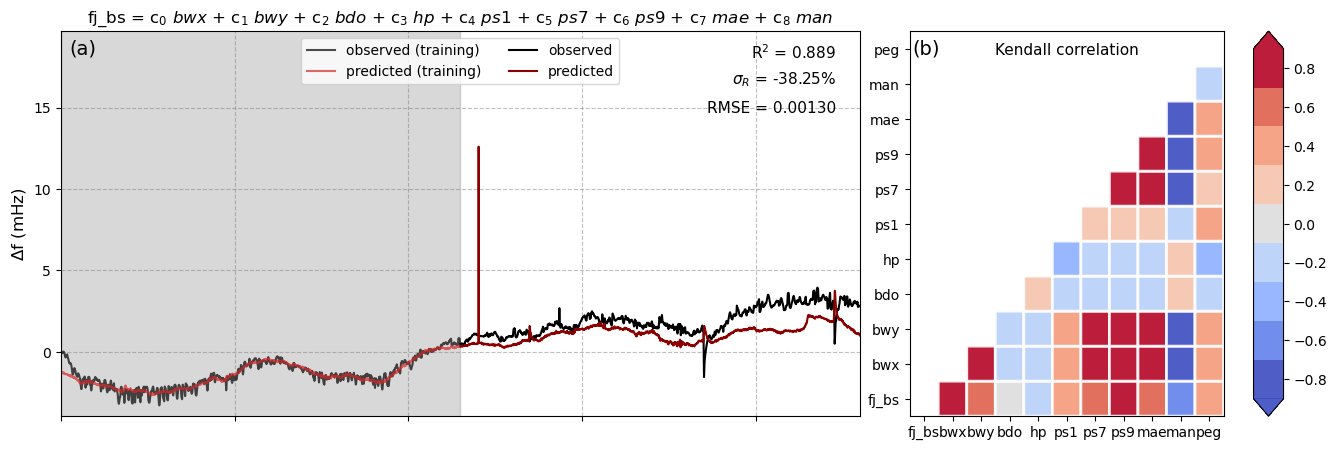

In [19]:
fig = __makeplot3(dfx, df1_part1, df1_part2,
                  t_predict, d_predict, out, targetx,
                  );

fig.savefig(config['path_to_figs']+f"SF_RV_sagnac_frequency_model.png", format="png", dpi=150, bbox_inches='tight')

In [ ]:
for i in range(10):
    print(i)

    out = __find_model(df1_part1, features_model, target=targetx, reg="ransac")

    t_predict, d_predict = __predict_data(df1_part2, features_model, out['model'], target=targetx)

    fig = __makeplot3(dfx, df1_part1, df1_part2,
                      t_predict, d_predict, out, targetx,
                      );

In [ ]:
# fig = __makeplot(dfx, out, targetx);

# fig.savefig(config['path_to_figs']+f"SF_BS_RU_shortterm_model_{config['tbeg'].date}_{config['tend'].date}_.png", format="png", dpi=150, bbox_inches='tight')


In [ ]:
# fig = __makeplot_corr_matrix(dfx, targetx, m="pearson")

# fig.savefig(config['path_to_figs']+f"BW_ccmatrix_{config['tbeg'].date}_{config['tend'].date}_.png", format="png", dpi=150, bbox_inches='tight')


## Modelling

### Beam Wander

In [20]:
def __makeplot(df0, modell, target):

    import matplotlib.pyplot as plt

    tscale = 1/86400

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax.plot(df0.time*tscale, df0[target], color="k", label="observed")
    ax.plot(modell['tp']*tscale, modell['dp'], color="tab:red", label="predicted")

    ax.grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

    ax.legend(loc=4, fontsize=font-2)

    ax.set_ylabel(f"Displacement (mm)", fontsize=font)
    ax.set_xlabel("Time (days)", fontsize=font)

    ax.text(0.01, 0.97, f"R$^2$={modell['r2']:.3f}", ha="left", va="top", transform=ax.transAxes, fontsize=font-1)

    ax.set_xlim(min(df0.time*tscale), max(df0.time*tscale))

    ax.set_title(target)

    plt.show();
    return fig

In [21]:

features = ['time', 'bwx', 'bwy', 'bdo', 'ps1', 'ps7', 'ps9', 'mae', 'man']

df1 = df[features]

target = "bwy"

N = df1.shape[0]

df1_part1 = df1.iloc[:int(N/2)]
df1_part2 = df1.iloc[int(N/2):]

out = __find_model(df1, features, target=target, reg="ransac")

t_predict, d_predict = __predict_data(df1_part2, features, out['model'], target=target)


['bwx', 'bdo', 'ps1', 'ps7', 'ps9', 'mae', 'man']
R2: 0.9892435696335696
Coef:  [ 7.12292125e-01 -1.97271532e-01  1.02135007e-01 -3.84430136e-02
 -1.41493030e-02  1.47434494e+04 -3.68712235e+03]
bwx : 0.7122921249041981
bwy : -0.19727153159737526
bdo : 0.1021350065972028
hp : -0.03844301359081001
ps1 : -0.014149302992278262
ps7 : 14743.449405632813
ps9 : -3687.12235247697


     bwx       bwy       bdo       ps1       ps7       ps9       mae       man
bwx  NaN  0.874831 -0.244512 -0.079889  0.652137  0.889433  0.870626 -0.809030
bwy  NaN       NaN -0.365947 -0.110952  0.727539  0.846575  0.826088 -0.791696
bdo  NaN       NaN       NaN -0.120979 -0.373320 -0.312697 -0.256016  0.328628
ps1  NaN       NaN       NaN       NaN -0.283223 -0.104802 -0.145059  0.245726
ps7  NaN       NaN       NaN       NaN       NaN  0.703610  0.697972 -0.800109
ps9  NaN       NaN       NaN       NaN       NaN       NaN  0.884077 -0.832166
mae  NaN       NaN       NaN       NaN       NaN       NaN       NaN -0.842279
man  NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN


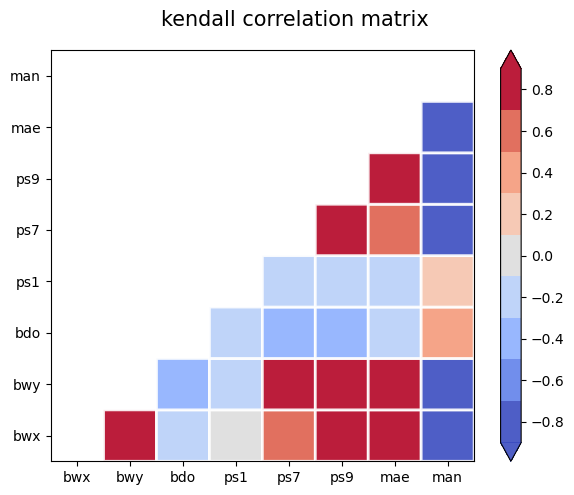

In [22]:
fig = __makeplot_corr_matrix(df1_part1, target, m="kendall")

# fig.savefig(config['path_to_figs']+f"SF_BS_RU_beamwander_{target}_ccmatrix.png", format="png", dpi=150, bbox_inches='tight')


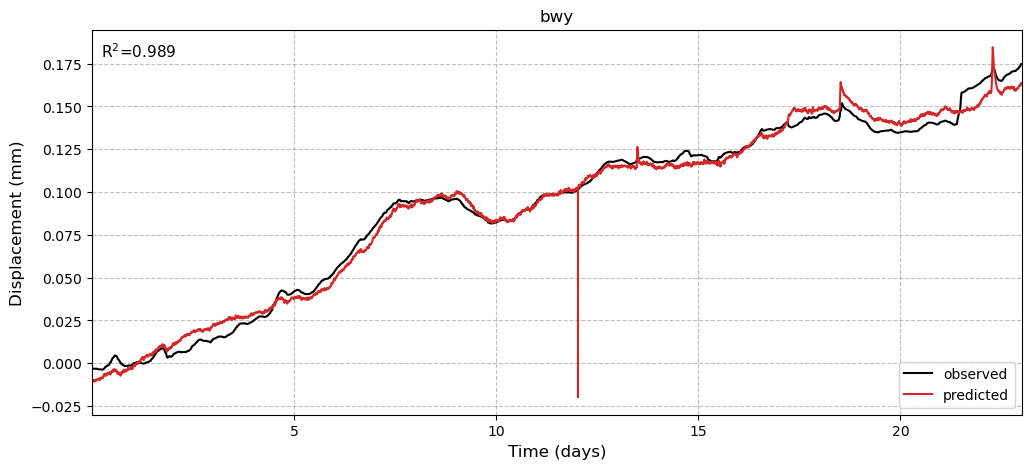

In [23]:
fig = __makeplot(df1, out, target)

# fig.savefig(config['path_to_figs']+f"SF_BS_RU_beamwander_{target}_predicted.png", format="png", dpi=150, bbox_inches='tight')


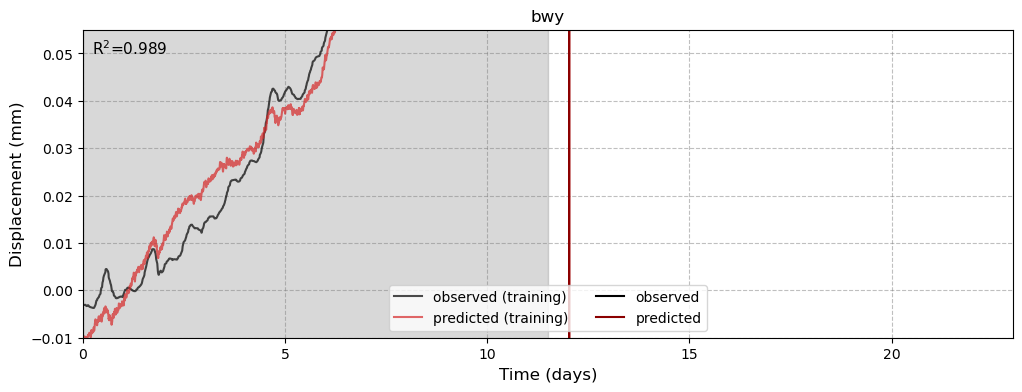

In [24]:
fig = __makeplot2(df1_part1, df1_part2, t_predict, d_predict, out, target);

In [ ]:
# # tbeg, tend = UTCDateTime(df1.time.min()), UTCDateTime(df1.time.max())
# tbeg = UTCDateTime("2024-04-20 18:00")
# tend = UTCDateTime("2024-04-30 00:00")

# bw = __load_beam_wander_data(tbeg.date, tend.date, data_path+"ids/data/")

# bw = bw[(bw.time > tbeg) & (bw.time < tend)]

# bw.time_utc = np.array([UTCDateTime(_t) for _t in bw.time])

# bw['x_mm'] = bw.x*1.67e-3
# bw['y_mm'] = bw.y*1.67e-3

# bw['x_mm'] = __reduce(bw.x_mm, 10)
# bw['y_mm'] = __reduce(bw.y_mm, 10)


## Both Components

In [34]:

features = ['time', 'bwx', 'bwy', 'bdo', 'hp', 'ps1', 'ps7', 'ps9', 'mae', 'man', 'peg']

df1 = df[features]

# get size of frame
N = df1.shape[0]

# split frame in two parts
df1_part1 = df1.iloc[:int(N/2)]
df1_part2 = df1.iloc[int(N/2):]

# set feature to model
target1 = "bwy"

features1 = ['bwy', 'bdo', 'hp', 'ps7', 'ps9', 'mae', 'man', 'peg']

# find model with first part of frame
out_y = __find_model(df1_part1, features1, target=target1, reg="theilsen")

# predict data for second part of frame
t_predict_y, d_predict_y = __predict_data(df1_part2, features1, out_y['model'], target=target1)


# fig = __makeplot_corr_matrix(df1_part1, target, m="kendall")

# fig = __makeplot2(df1_part1, df1_part2, t_predict_y, d_predict_y, out_y, target1);



# set feature to model
target2 = "bwx"

features2 = ['bwx', 'bdo', 'hp', 'ps7', 'ps9', 'mae', 'man']


# find model with first part of frame
out_x = __find_model(df1_part1, features2, target=target2, reg="theilsen")

# predict data for second part of frame
t_predict_x, d_predict_x = __predict_data(df1_part2, features2, out_x['model'], target=target2)


# fig = __makeplot_corr_matrix(df1_part1, target, m="kendall")

# fig = __makeplot2(df1_part1, df1_part2, t_predict_x, d_predict_x, out_x, target2);


['bdo', 'hp', 'ps7', 'ps9', 'mae', 'man', 'peg']
R2: 0.9860754690904688
X0: -0.00024954039070179755
Coef:  [-2.43217515e-01  4.86355904e-02 -5.59334147e-03  8.95232682e-02
  2.29520549e+03 -4.83100684e+03  1.30757042e-02]
bwx : -0.2432175153990789
bwy : 0.04863559040495405
bdo : -0.005593341467841477
hp : 0.08952326823209332
ps1 : 2295.2054858014694
ps7 : -4831.006838105823
ps9 : 0.013075704181839114
['bdo', 'hp', 'ps7', 'ps9', 'mae', 'man', 'peg']
R2: 0.9964848349775559
X0: 0.0012851862100390966
Coef:  [-1.20203448e-01  3.28180426e-02 -1.36577151e-02  6.55487622e-02
  8.48533097e+03 -6.42670975e+03  2.31886796e-02]
bwx : -0.12020344845265968
bwy : 0.03281804258311678
bdo : -0.013657715113192479
hp : 0.06554876221520863
ps1 : 8485.330967359294
ps7 : -6426.709750844424
ps9 : 0.0231886795573415


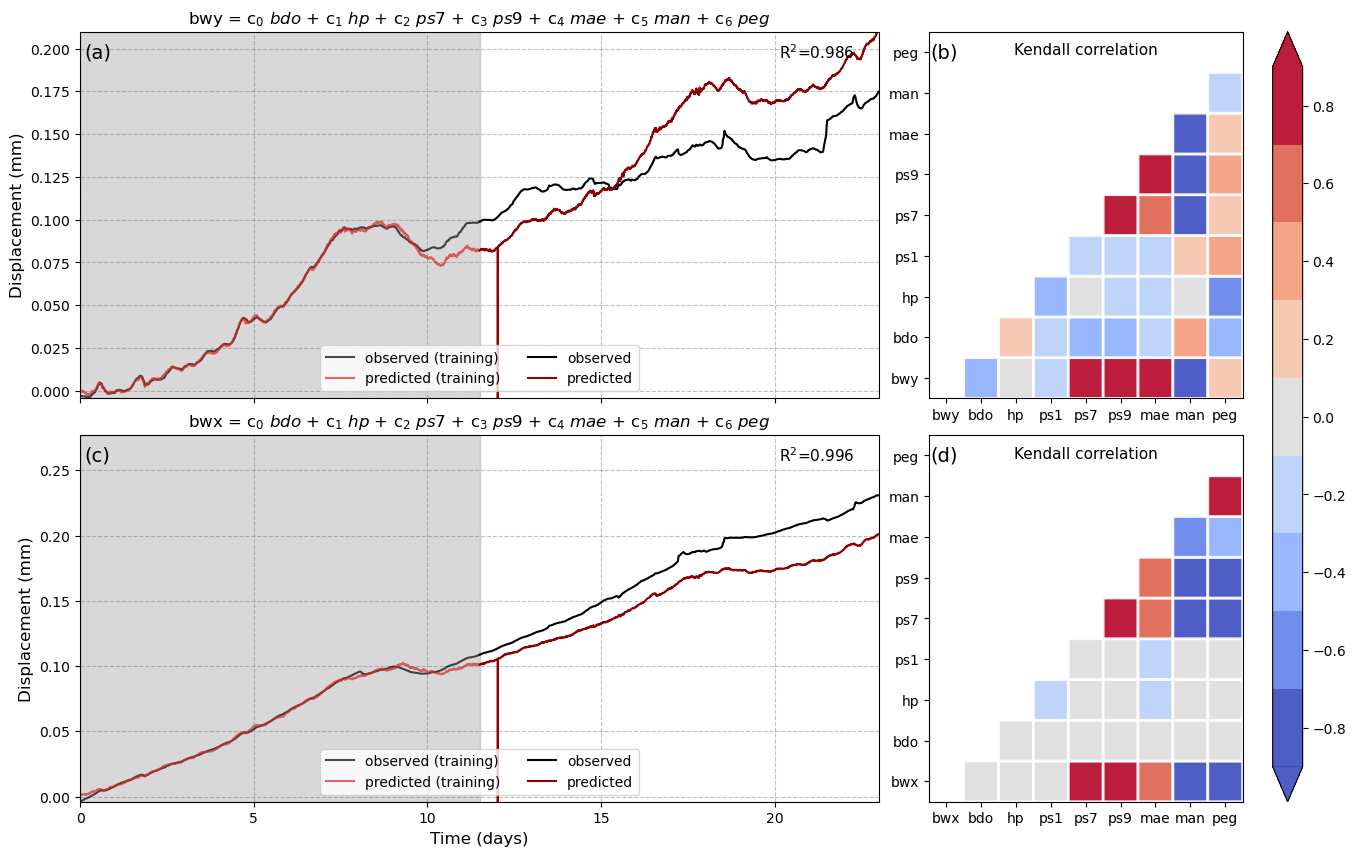

In [35]:
def __makeplot3(df0, df1, df2,
                tp1, dp1, model1, target1,
                tp2, dp2, model2, target2
               ):

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec

    def __corr(df_in, m="kendall", targetx="not_the_one"):

        _df = df_in.copy()

        if "time" in list(_df.columns):
            _df.drop(columns="time", inplace=True)
            _df.drop(columns=targetx, inplace=True)

        _df = _df.iloc[:, :]

        corr = _df.corr(method=m.lower())

        # mask upper triangle
        corr[:] = np.where(np.arange(corr.shape[0])[:, None] >= np.arange(corr.shape[1]), np.nan, corr)

        return corr

    c_method = "Kendall" # kendall pearson spearman


    corr1 = __corr(df1, m=c_method, targetx=target2)

    corr2 = __corr(df2, m=c_method, targetx=target1)


    # _________________________________________
    #

    tscale = 1/86400

    Nrow, Ncol = 2, 10

    cmap = plt.get_cmap("coolwarm", 9)

    fig = plt.figure(figsize=(15, 10))

    font = 12

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0.1, wspace=0.7)

    ax0 = fig.add_subplot(gs[0, :7])
    ax1 = fig.add_subplot(gs[0, 7:])
    ax2 = fig.add_subplot(gs[1, :7])
    ax3 = fig.add_subplot(gs[1, 7:])

    axes = [ax0, ax1, ax2, ax3]


    ax0.plot(df1.time*tscale, df1[target1], color="k", label="observed (training)", alpha=0.7)
    ax0.plot(model1['tp']*tscale, model1['dp'], color="tab:red", label="predicted (training)", alpha=0.7)

    ax0.fill_betweenx([-1000, 1000], df1.time.min()*tscale, df1.time.max()*tscale, color="grey", alpha=0.3)

    ax0.plot(df2.time*tscale, df2[target1], color="k", label="observed")
    ax0.plot(tp1*tscale, dp1, color="darkred", label="predicted")

    ax0.set_xticklabels([])

    im1 = ax1.pcolor(corr1, cmap=cmap, vmin=-.9, vmax=.9, edgecolors='w', linewidths=2, alpha=0.9)

    # add colorbar
    cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77]) #[left, bottom, width, height]
    cb = plt.colorbar(im1, cax=cbar_ax, extend="both")

    labels = list(corr1.columns)
    # ax1.yaxis.set_label_position("right")
    # ax1.yaxis.tick_right()
    ax1.set_xticks(np.arange(len(labels))+0.5)
    ax1.set_xticklabels(labels)
    ax1.set_yticks(np.arange(len(labels))+0.5)
    # ax1.set_yticklabels(reversed(labels))
    ax1.set_yticklabels(labels)

    ax1.text(0.5, 0.97, f"{c_method} correlation", ha="center", va="top", transform=ax1.transAxes, fontsize=font-1)

    ax2.plot(df1.time*tscale, df1[target2], color="k", label="observed (training)", alpha=0.7)
    ax2.plot(model2['tp']*tscale, model2['dp'], color="tab:red", label="predicted (training)", alpha=0.7)

    ax2.fill_betweenx([df0[target2].min()*1.2, df0[target2].max()*1.2], df1.time.min()*tscale, df1.time.max()*tscale, color="grey", alpha=0.3)

    ax2.plot(df2.time*tscale, df2[target2], color="k", label="observed")
    ax2.plot(tp2*tscale, dp2, color="darkred", label="predicted")


    im2 = ax3.pcolor(corr2, cmap=cmap, vmin=-.9, vmax=.9, edgecolors='w', linewidths=2, alpha=0.9)
    # plt.colorbar(im2, extend="both")

    labels = list(corr2.columns)
    # ax3.yaxis.set_label_position("right")
    # ax3.yaxis.tick_right()
    ax3.set_xticks(np.arange(len(labels))+0.5)
    ax3.set_xticklabels(labels)
    ax3.set_yticks(np.arange(len(labels))+0.5)
    ax3.set_yticklabels(labels)

    ax3.text(0.5, 0.97, f"{c_method} correlation", ha="center", va="top", transform=ax3.transAxes, fontsize=font-1)


    for ax in [ax0, ax2]:

        ax.grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)
        ax.legend(loc=8, fontsize=font-2, ncol=2)
        ax.set_ylabel(f"Displacement (mm)", fontsize=font)

    ax0.text(0.97, 0.97, f"R$^2$={model1['r2']:.3f}", ha="right", va="top", transform=ax0.transAxes, fontsize=font-1)
    ax2.text(0.97, 0.97, f"R$^2$={model2['r2']:.3f}", ha="right", va="top", transform=ax2.transAxes, fontsize=font-1)

    ax0.set_xlim(0, df2.time.max()*tscale)
    ax2.set_xlim(0, df2.time.max()*tscale)

    # ax0.set_ylim(-0.01, 0.055)
    # ax2.set_ylim(-0.002, 0.005)

    ax0.set_ylim(df0[target1].min()*1.2, df0[target1].max()*1.2)
    ax2.set_ylim(df0[target2].min()*1.2, df0[target2].max()*1.2)

    mod = ""
    for i, ll in enumerate(features1):
        mod += f"c$_{i}$ ${ll}$ + "

    tit1 = f"{target1} = {mod}"
    ax0.set_title(tit1[:-2])

    mod = ""
    for i, ll in enumerate(features2):
        mod += f"c$_{i}$ ${ll}$ + "

    tit2 = f"{target2} = {mod}"
    ax2.set_title(tit2[:-2])

    ax2.set_xlabel(f"Time (days)", fontsize=font)


    axes = [ax0, ax1, ax2, ax3]
    for _k, (ax, ll) in enumerate(zip(axes, ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)'])):
        ax.text(.005, .97, ll, ha='left', va='top', transform=ax.transAxes, fontsize=font+2)


    plt.show();
    return fig


fig = __makeplot3(df1, df1_part1, df1_part2,
                  t_predict_y, d_predict_y, out_y, target1,
                  t_predict_x, d_predict_x, out_x, target2,
                  );

fig.savefig(config['path_to_figs']+f"SF_RV_beamwander_model.png", format="png", dpi=150, bbox_inches='tight')


In [29]:
def __makeplot_overview(df0, df1, tp, dp, model, target):

    import matplotlib.pyplot as plt

    tscale = 1/86400

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 4), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax.plot(df0.time*tscale, df0[target], color="k", label="observed (training)", alpha=0.7)
    ax.plot(model['tp']*tscale, model['dp'], color="tab:red", label="predicted (training)", alpha=0.7)

    ax.fill_betweenx([-1000, 1000], df0.time.min()*tscale, df0.time.max()*tscale, color="grey", alpha=0.3)

    ax.plot(df1.time*tscale, df1[target], color="k", label="observed")
    ax.plot(tp*tscale, dp, color="darkred", label="predicted")

    ax.grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

    ax.legend(loc=8, fontsize=font-2, ncol=2)

    ax.set_ylabel(f"Displacement (mm)", fontsize=font)
    ax.set_xlabel("Time (days)", fontsize=font)

    ax.text(0.01, 0.97, f"R$^2$={out['r2']:.3f}", ha="left", va="top", transform=ax.transAxes, fontsize=font-1)

    ax.set_xlim(0, df1.time.max()*tscale)

    ax.set_ylim(-0.01, 0.055)

    ax.set_title(target)

    plt.show();
    return fig

# __makeplot_overview(df0, df1, tp, dp, model, target)


In [ ]:
pd.plotting.scatter_matrix(df1_part1,
                           figsize=(15, 15),
                           alpha=0.2,
                           diagonal="hist",
                          );


In [ ]:

# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn import linear_model
# from mpl_toolkits.mplot3d import Axes3D

# ######################################## Data preparation #########################################

# X = df[['mae', 'man']].values.reshape(-1, 2)
# Y = df['fj_bs']

# ######################## Prepare model data point for visualization ###############################

# x = X[:, 0]
# y = X[:, 1]
# z = Y

# x_pred = np.linspace(6, 24, 30)      # range of porosity values
# y_pred = np.linspace(0.93, 2.9, 30)  # range of VR values
# xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
# model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

# ################################################ Train #############################################

# ols = linear_model.LinearRegression()
# model = ols.fit(X, Y)
# predicted = model.predict(model_viz)

# ############################################## Evaluate ############################################

# r2 = model.score(X, Y)

# ############################################## Plot ################################################

# plt.style.use('default')

# fig = plt.figure(figsize=(12, 4))

# ax1 = fig.add_subplot(131, projection='3d')
# ax2 = fig.add_subplot(132, projection='3d')
# ax3 = fig.add_subplot(133, projection='3d')

# axes = [ax1, ax2, ax3]

# for ax in axes:
#     ax.plot(x, y, z, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
#     ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
#     ax.set_xlabel('Porosity (%)', fontsize=12)
#     ax.set_ylabel('VR', fontsize=12)
#     ax.set_zlabel('Gas Prod. (Mcf/day)', fontsize=12)
#     ax.locator_params(nbins=4, axis='x')
#     ax.locator_params(nbins=5, axis='x')

# ax1.text2D(0.2, 0.32, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
#            transform=ax1.transAxes, color='grey', alpha=0.5)
# ax2.text2D(0.3, 0.42, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
#            transform=ax2.transAxes, color='grey', alpha=0.5)
# ax3.text2D(0.85, 0.85, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
#            transform=ax3.transAxes, color='grey', alpha=0.5)

# ax1.view_init(elev=27, azim=112)
# ax2.view_init(elev=16, azim=-51)
# ax3.view_init(elev=60, azim=165)

# fig.suptitle('$R^2 = %.2f$' % r2, fontsize=20)

# fig.tight_layout();

